# Imports

In [16]:
from google.cloud import bigquery
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(40, 25))
plt.rc("font", size=24)

import math
from scipy import fft
from scipy import signal as sig

# Reading Queries

In [17]:
total_signups_query = open('Queries/total_signups_query.sql', 'r').read()
signup_completed_query = open('Queries/signup_completed_query.sql', 'r').read()
devs_vetted_query = open('Queries/devs_vetted_query.sql', 'r').read()
devs_shortlisted_query = open('Queries/devs_shortlisted_query.sql', 'r').read()
devs_chosen_query = open('Queries/devs_chosen_query.sql', 'r').read()

# Useful Functions

In [18]:
def query_result(query):
    client = bigquery.Client('turing-230020')
    output = client.query(query).to_dataframe()
    client.close()
    return output

def data_preprocess(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df[df['date'] >= '2019-09-01']

    date_range = pd.date_range(df['date'].min(), df['date'].max())

    df = df.set_index('date')
    df = df.reindex(date_range, fill_value=0)
    df = df.reset_index()
    #df.columns = ['ds', 'y']
    #df['ds'] = df['ds'].dt.tz_localize(None)
    df['mean'] = df['devs_count'].rolling(window=7).mean()
    # df['devs_count'] = df['devs_count'] - df['devs_count'].mean()
    
    return df

def single_period(output, fft_output, N, ax1):
    seasonality = np.array([f if i == output['index'] else 0 for i, f in enumerate(fft_output)])
    seasonality = fft.ifft(seasonality)
    ax1.plot(df['index'][:N], seasonality[:N].real, linewidth=1, label=output['period (days)'])
    filtered_sig_peaks = sig.find_peaks(seasonality.real, prominence=1)[0]
    print("-----------", output['period (days)'], "------------")
    print(df['index'][filtered_sig_peaks].head())
    print(df['index'][filtered_sig_peaks].apply(lambda d: d.weekday()).head())
    
    return seasonality

def get_seasonality(df):
    fft_output = fft.fft(df['devs_count'])
    power = np.abs(fft_output)
    freq = fft.fftfreq(len(df))

    mask = freq >= 0
    freq = freq[mask]
    power = power[mask]
    
    peaks = sig.find_peaks(power[freq >=0], prominence=10**3)[0]
    peak_freq =  freq[peaks]
    peak_power = power[peaks]
    
    output = pd.DataFrame()
    output['index'] = peaks
    output['freq (1/hour)'] = peak_freq
    output['amplitude'] = peak_power
    output['period (days)'] = 1 / peak_freq
    output['fft'] = fft_output[peaks]
    output = output.sort_values('amplitude', ascending=False)
    
    output = output[:3].reset_index()
   
    N = df.shape[0]
    
    ax1 = plt.subplot(3, 1, 1)
    
    seasonality = 0
    for index, row in output.iterrows():
        seasonality += single_period(row, fft_output, N, ax1).real

    ax1.legend(loc='upper right')
    ax1.grid()
    plt.xticks(rotation=45)
    
    return seasonality

def get_trend(df):
    ax2 = plt.subplot(3, 1, 2)
    
    trend = df['devs_count'].rolling(window=14).median()
    trend[:13] = df['devs_count'][:13]
    ax2.plot(df['index'], trend)
    
    plt.xticks(rotation=45)

    return trend

def get_error(df, trend, seasonality):
    ax3 = plt.subplot(3, 1, 3)
    
    error = df['devs_count'] - trend - seasonality
    
    ax3.plot(df['index'], error)
    plt.xticks(rotation=45)

    return error

def get_anomalies(resid, seasonal, trend, df):
    res_mean = resid.mean()
    resid_std = resid.std()

    lower_bound = res_mean - 2*resid_std
    upper_bound = res_mean + 2*resid_std

    cleaned_data = seasonal + trend
    
    anomalies = df[(resid < lower_bound) | (resid > upper_bound)]
    anomalies['day_name'] = (anomalies['index'].dt.day_name()).values
    
    return anomalies

# Data

In [4]:
total_signups = query_result(total_signups_query)
total_signups = data_preprocess(total_signups)

signup_completed = query_result(signup_completed_query)
signup_completed = data_preprocess(signup_completed)

devs_vetted = query_result(devs_vetted_query)
devs_vetted = data_preprocess(devs_vetted)

devs_shortlisted = query_result(devs_shortlisted_query)
devs_shortlisted = data_preprocess(devs_shortlisted)

devs_chosen = query_result(devs_chosen_query)
devs_chosen = data_preprocess(devs_chosen)

# Fourier Transforms

----------- (364.6666666666667+0j) ------------
212   2020-03-31 00:00:00+00:00
577   2021-03-31 00:00:00+00:00
942   2022-03-31 00:00:00+00:00
Name: index, dtype: datetime64[ns, UTC]
212    1
577    2
942    3
Name: index, dtype: int64
----------- (156.28571428571428+0j) ------------
87    2019-11-27 00:00:00+00:00
243   2020-05-01 00:00:00+00:00
399   2020-10-04 00:00:00+00:00
555   2021-03-09 00:00:00+00:00
712   2021-08-13 00:00:00+00:00
Name: index, dtype: datetime64[ns, UTC]
87     2
243    4
399    6
555    1
712    4
Name: index, dtype: int64
----------- (7.012820512820514+0j) ------------
1    2019-09-02 00:00:00+00:00
8    2019-09-09 00:00:00+00:00
15   2019-09-16 00:00:00+00:00
22   2019-09-23 00:00:00+00:00
29   2019-09-30 00:00:00+00:00
Name: index, dtype: datetime64[ns, UTC]
1     0
8     0
15    0
22    0
29    0
Name: index, dtype: int64


/tmp/ipykernel_1354/271925524.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies['index'].dt.day_name()).values


,index,devs_count,mean,day_name
315,2020-07-12 00:00:00+00:00,1268,241.000000,Sunday
359,2020-08-25 00:00:00+00:00,1602,280.000000,Tuesday
476,2020-12-20 00:00:00+00:00,1596,967.857143,Sunday
509,2021-01-22 00:00:00+00:00,2318,1391.714286,Friday
530,2021-02-12 00:00:00+00:00,2685,1490.428571,Friday
...,...,...,...,...
1029,2022-06-26 00:00:00+00:00,1901,2369.000000,Sunday
1067,2022-08-03 00:00:00+00:00,2748,1477.285714,Wednesday
1068,2022-08-04 00:00:00+00:00,3125,1705.571429,Thursday
1072,2022-08-08 00:00:00+00:00,3204,2180.000000,Monday


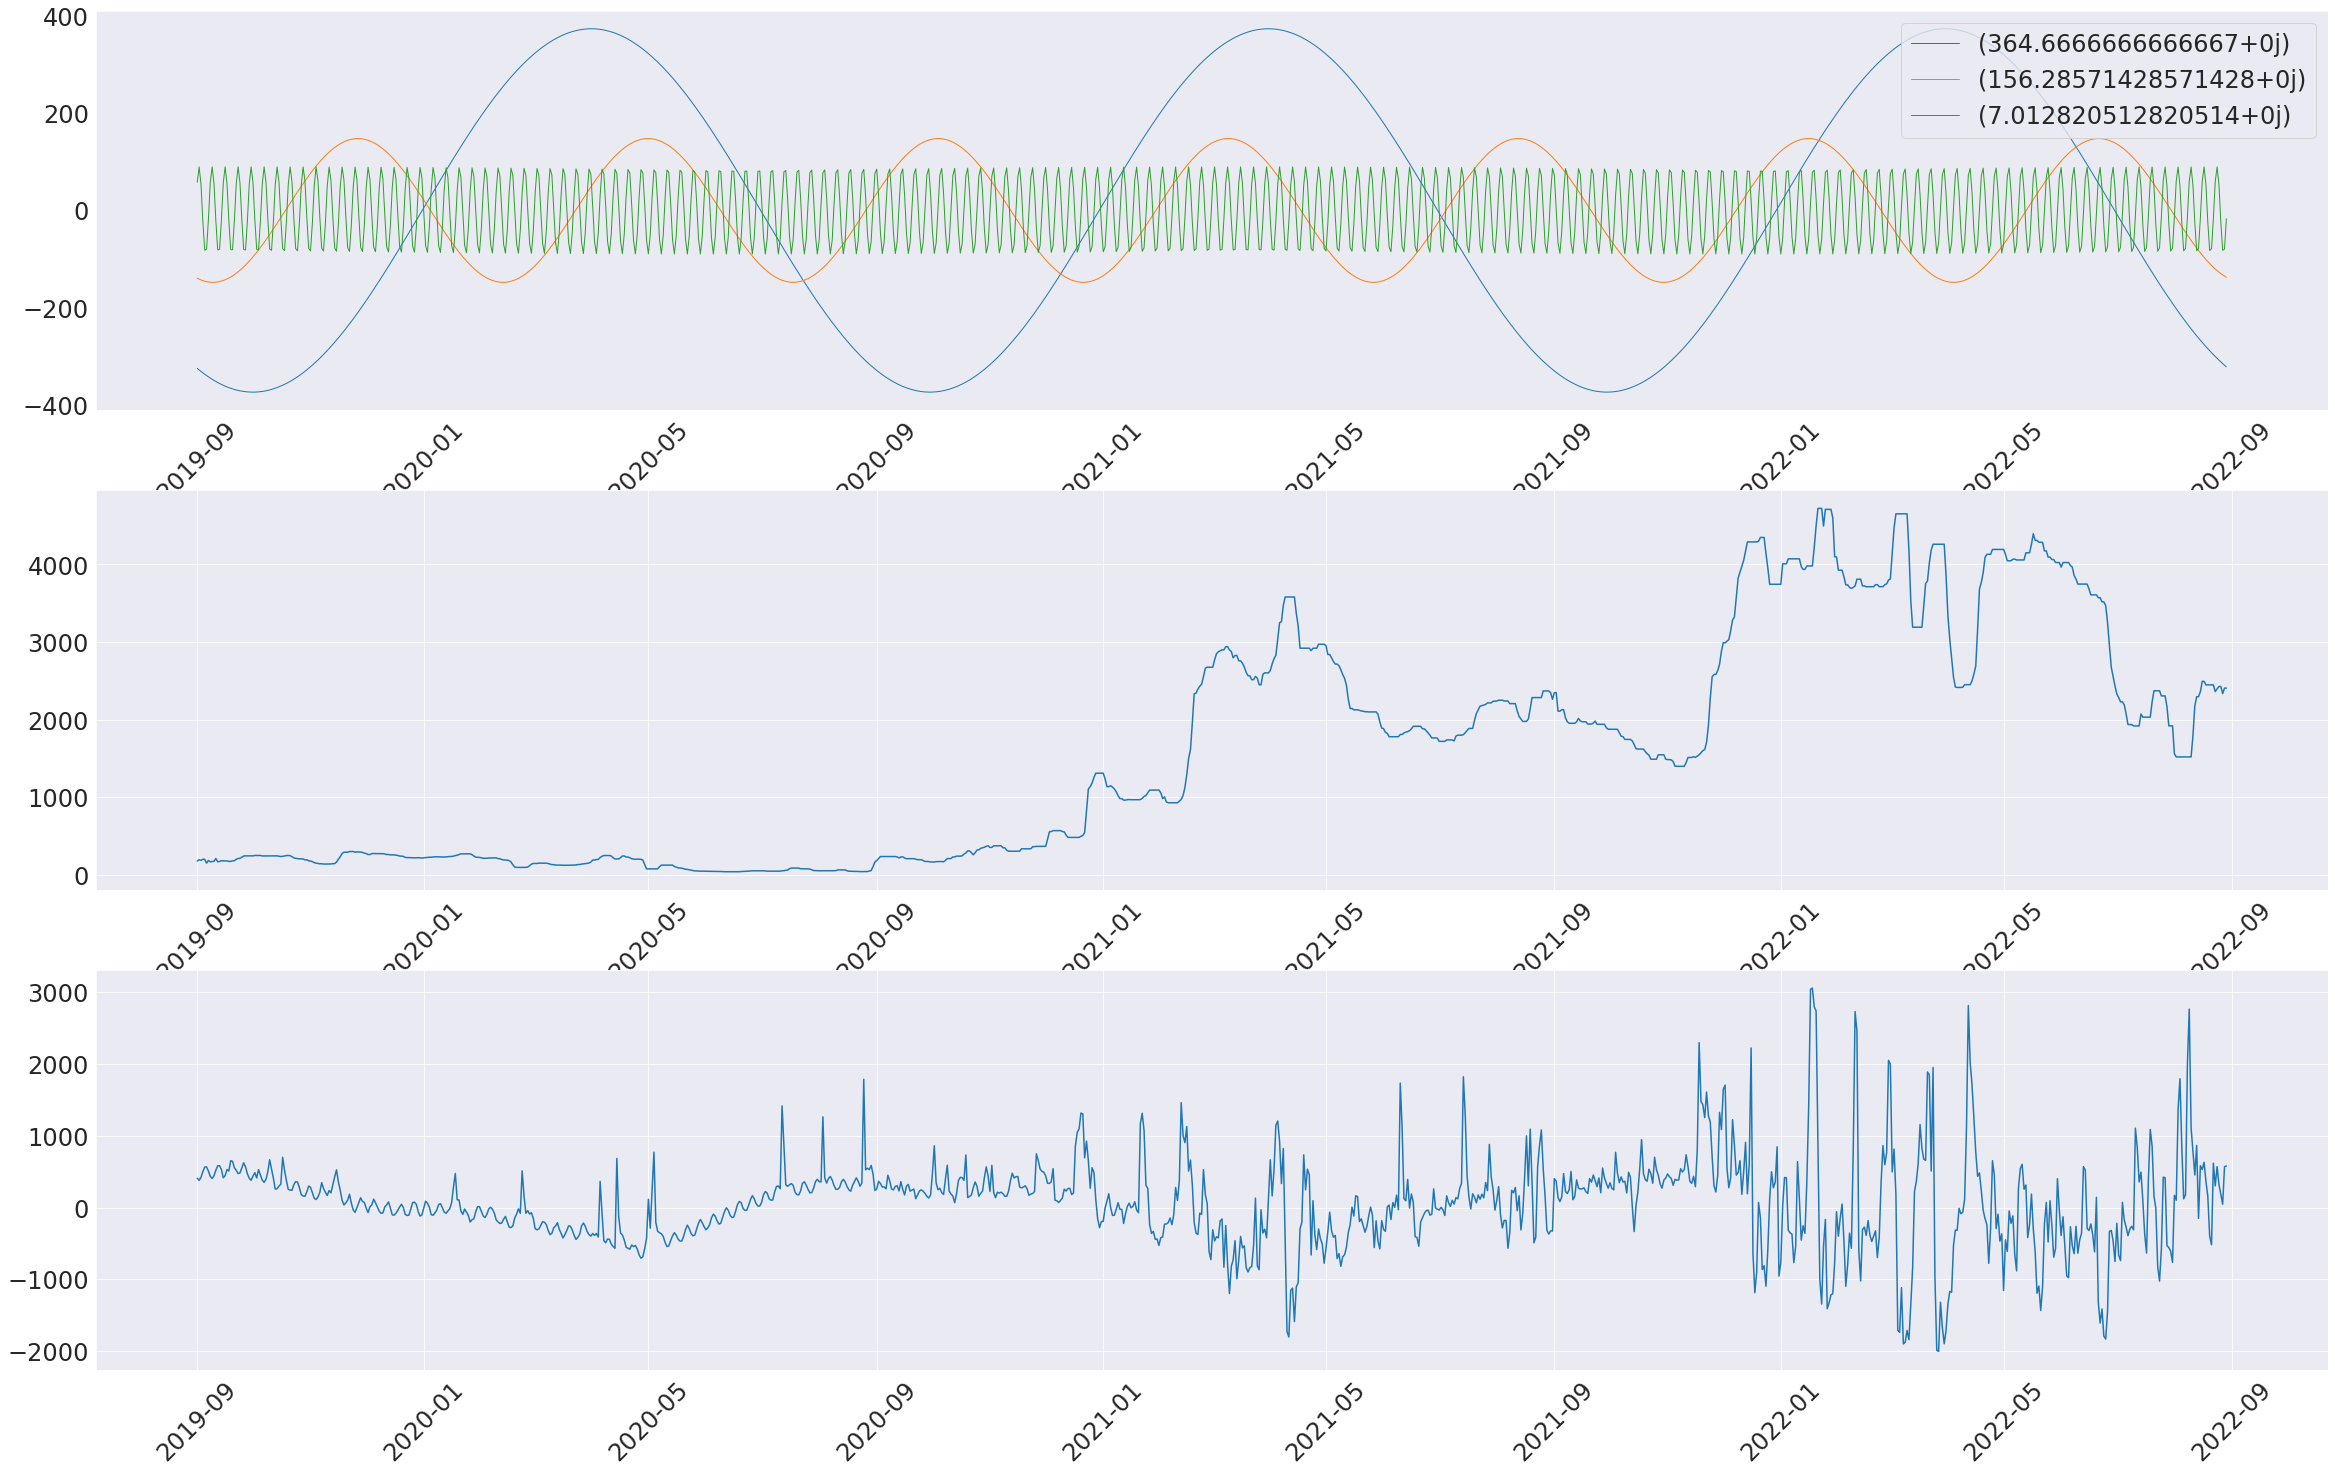

In [19]:
df = total_signups

seasonal = get_seasonality(df)
trend = get_trend(df)
error = get_error(df, trend, seasonal)

get_anomalies(error, seasonal, trend, df)

----------- (6.970588235294118+0j) ------------
7    2021-05-20
14   2021-05-27
21   2021-06-03
28   2021-06-10
35   2021-06-17
Name: index, dtype: datetime64[ns]
7     3
14    3
21    3
28    3
35    3
Name: index, dtype: int64
----------- (158.00000000000003+0j) ------------
72    2021-07-24
230   2021-12-29
388   2022-06-05
Name: index, dtype: datetime64[ns]
72     5
230    2
388    6
Name: index, dtype: int64
----------- (79.00000000000001+0j) ------------
60    2021-07-12
139   2021-09-29
218   2021-12-17
297   2022-03-06
376   2022-05-24
Name: index, dtype: datetime64[ns]
60     0
139    2
218    4
297    6
376    1
Name: index, dtype: int64


/tmp/ipykernel_1354/271925524.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies['index'].dt.day_name()).values


,index,devs_count,mean,day_name
28,2021-06-10,1923,1013.000000,Thursday
29,2021-06-11,1587,1128.714286,Friday
89,2021-08-10,22,718.571429,Tuesday
90,2021-08-11,55,586.000000,Wednesday
189,2021-11-18,1679,947.857143,Thursday
217,2021-12-16,2907,1990.714286,Thursday
249,2022-01-17,3132,1962.714286,Monday
250,2022-01-18,2912,2119.571429,Tuesday
251,2022-01-19,3101,2317.000000,Wednesday
252,2022-01-20,3226,2532.285714,Thursday


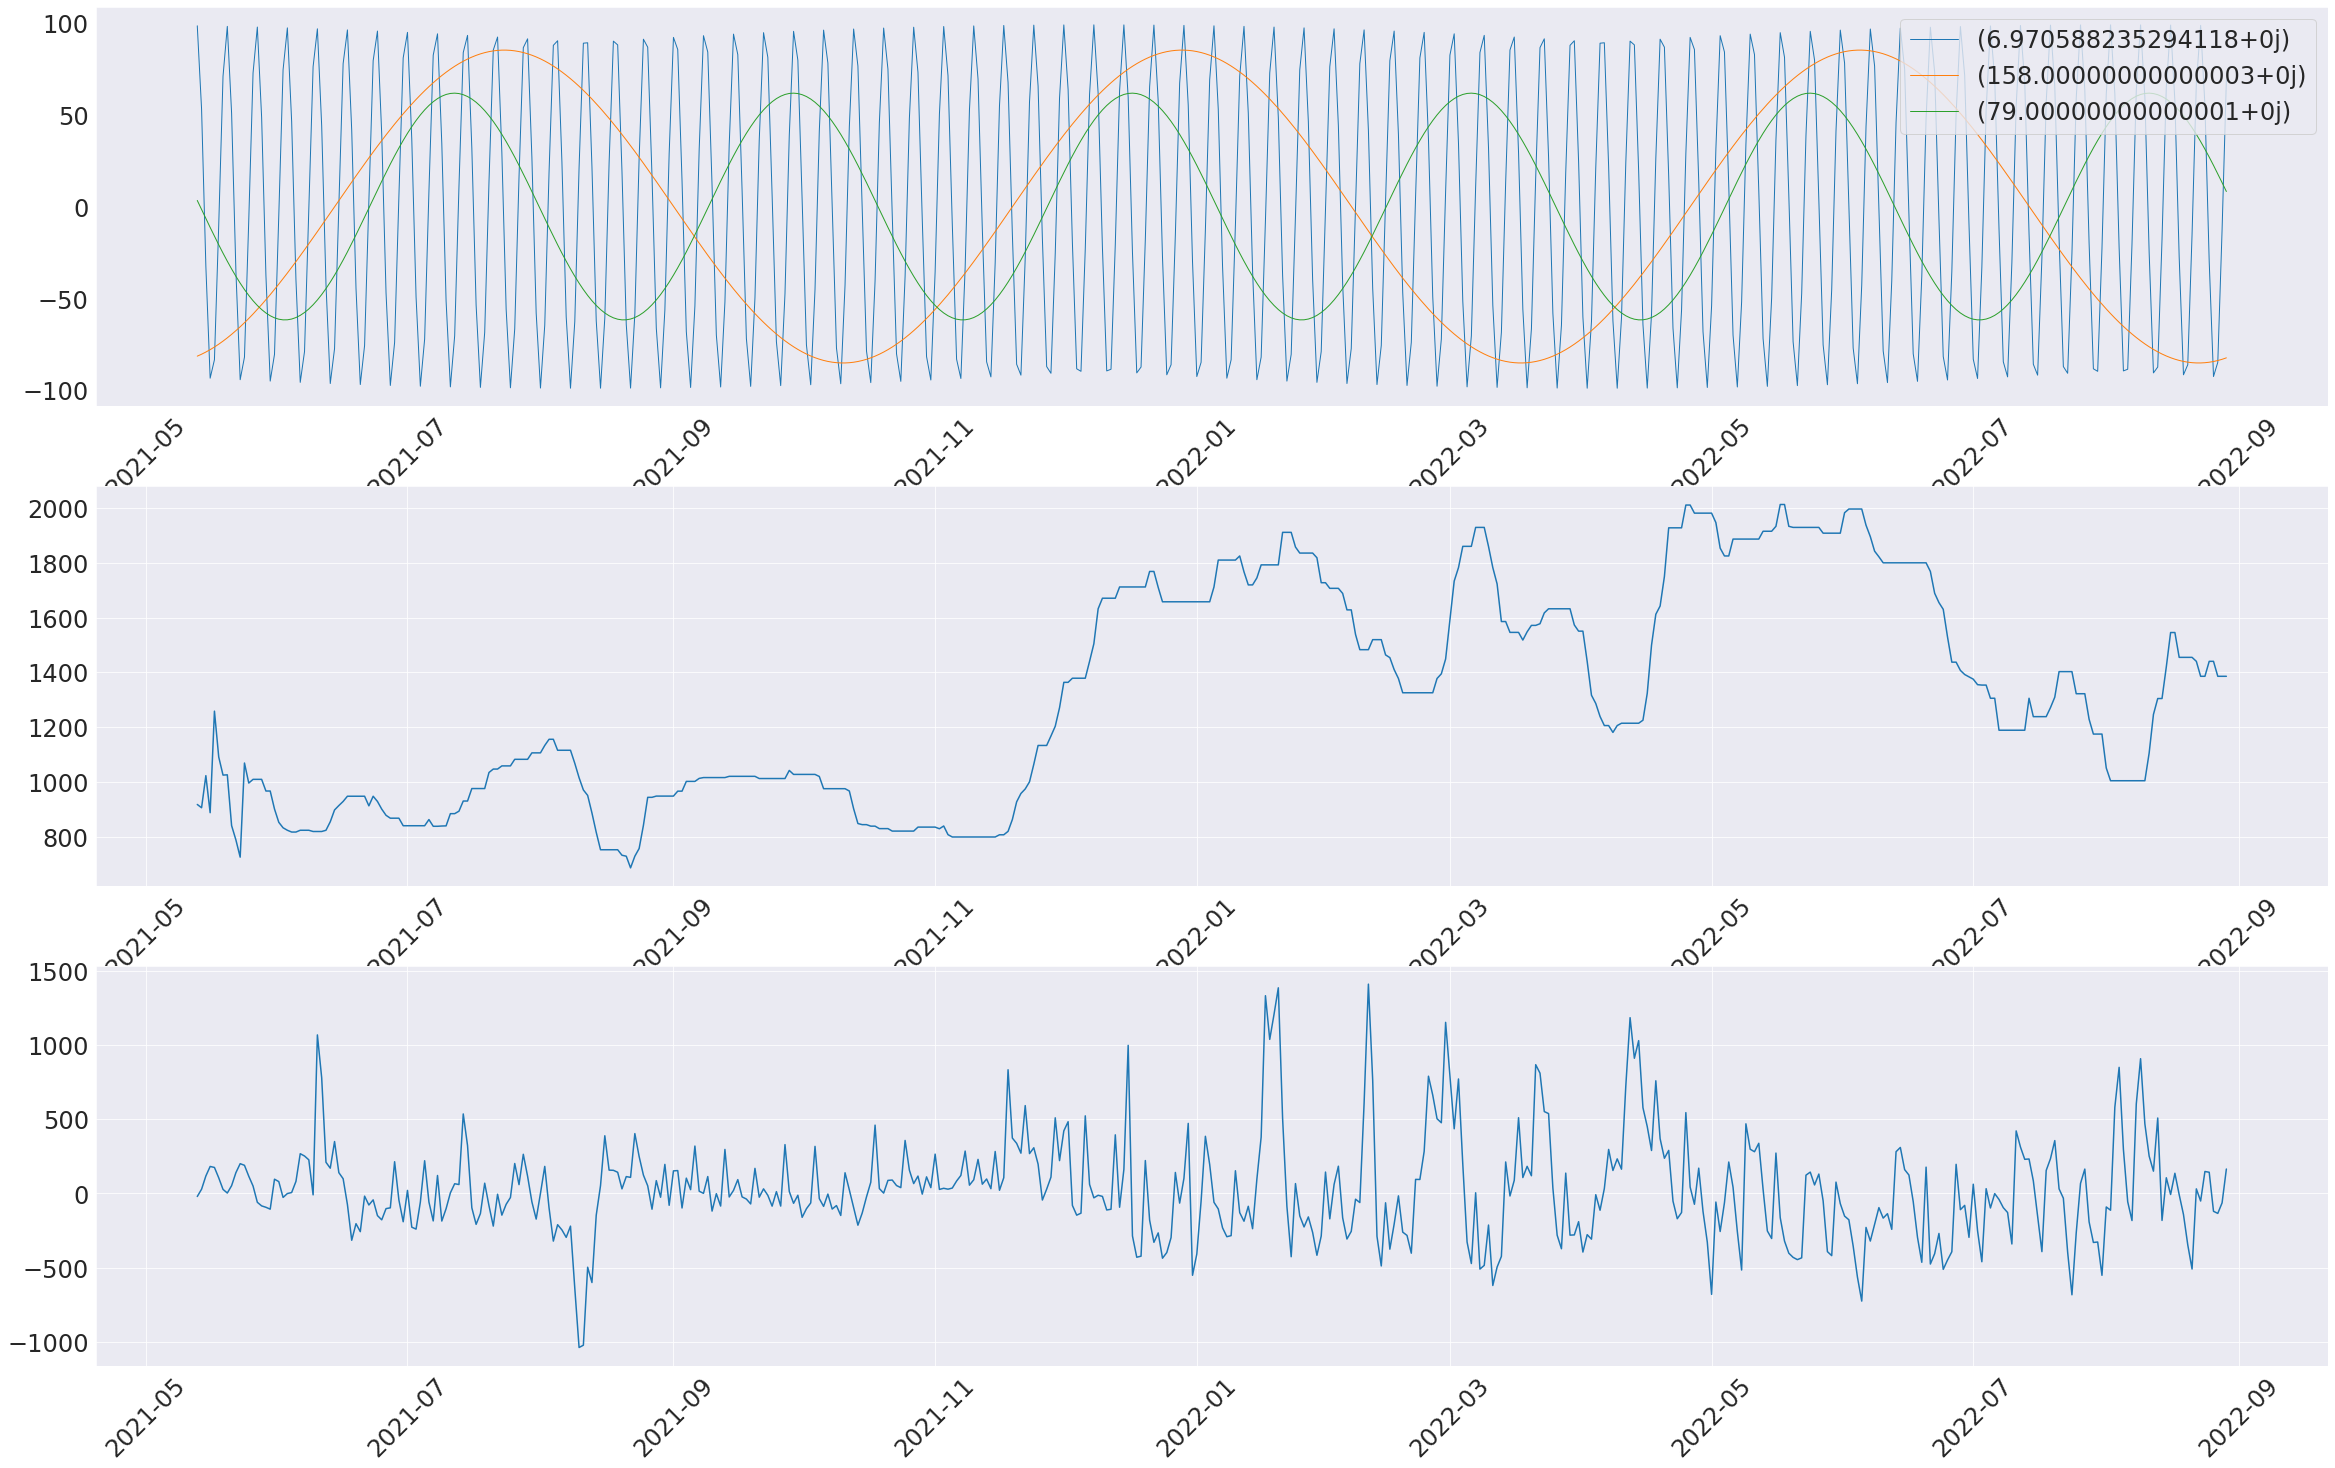

In [20]:
df = signup_completed

seasonal = get_seasonality(df)
trend = get_trend(df)
error = get_error(df, trend, seasonal)

get_anomalies(error, seasonal, trend, df)

----------- (347+0j) ------------
283   2020-08-02
630   2021-07-15
977   2022-06-27
Name: index, dtype: datetime64[ns]
283    6
630    3
977    0
Name: index, dtype: int64
----------- (115.66666666666669+0j) ------------
88    2020-01-20
203   2020-05-14
319   2020-09-07
435   2021-01-01
550   2021-04-26
Name: index, dtype: datetime64[ns]
88     0
203    3
319    0
435    4
550    0
Name: index, dtype: int64
----------- (80.07692307692308+0j) ------------
62    2019-12-25
142   2020-03-14
222   2020-06-02
302   2020-08-21
382   2020-11-09
Name: index, dtype: datetime64[ns]
62     2
142    5
222    1
302    4
382    0
Name: index, dtype: int64


/tmp/ipykernel_1354/271925524.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies['index'].dt.day_name()).values


,index,devs_count,mean,day_name
502,2021-03-09,81,40.285714,Tuesday
514,2021-03-21,57,28.857143,Sunday
613,2021-06-28,94,51.857143,Monday
653,2021-08-07,147,94.857143,Saturday
655,2021-08-09,230,116.000000,Monday
657,2021-08-11,70,122.285714,Wednesday
663,2021-08-17,190,86.571429,Tuesday
664,2021-08-18,132,95.428571,Wednesday
665,2021-08-19,182,111.571429,Thursday
676,2021-08-30,74,89.428571,Monday


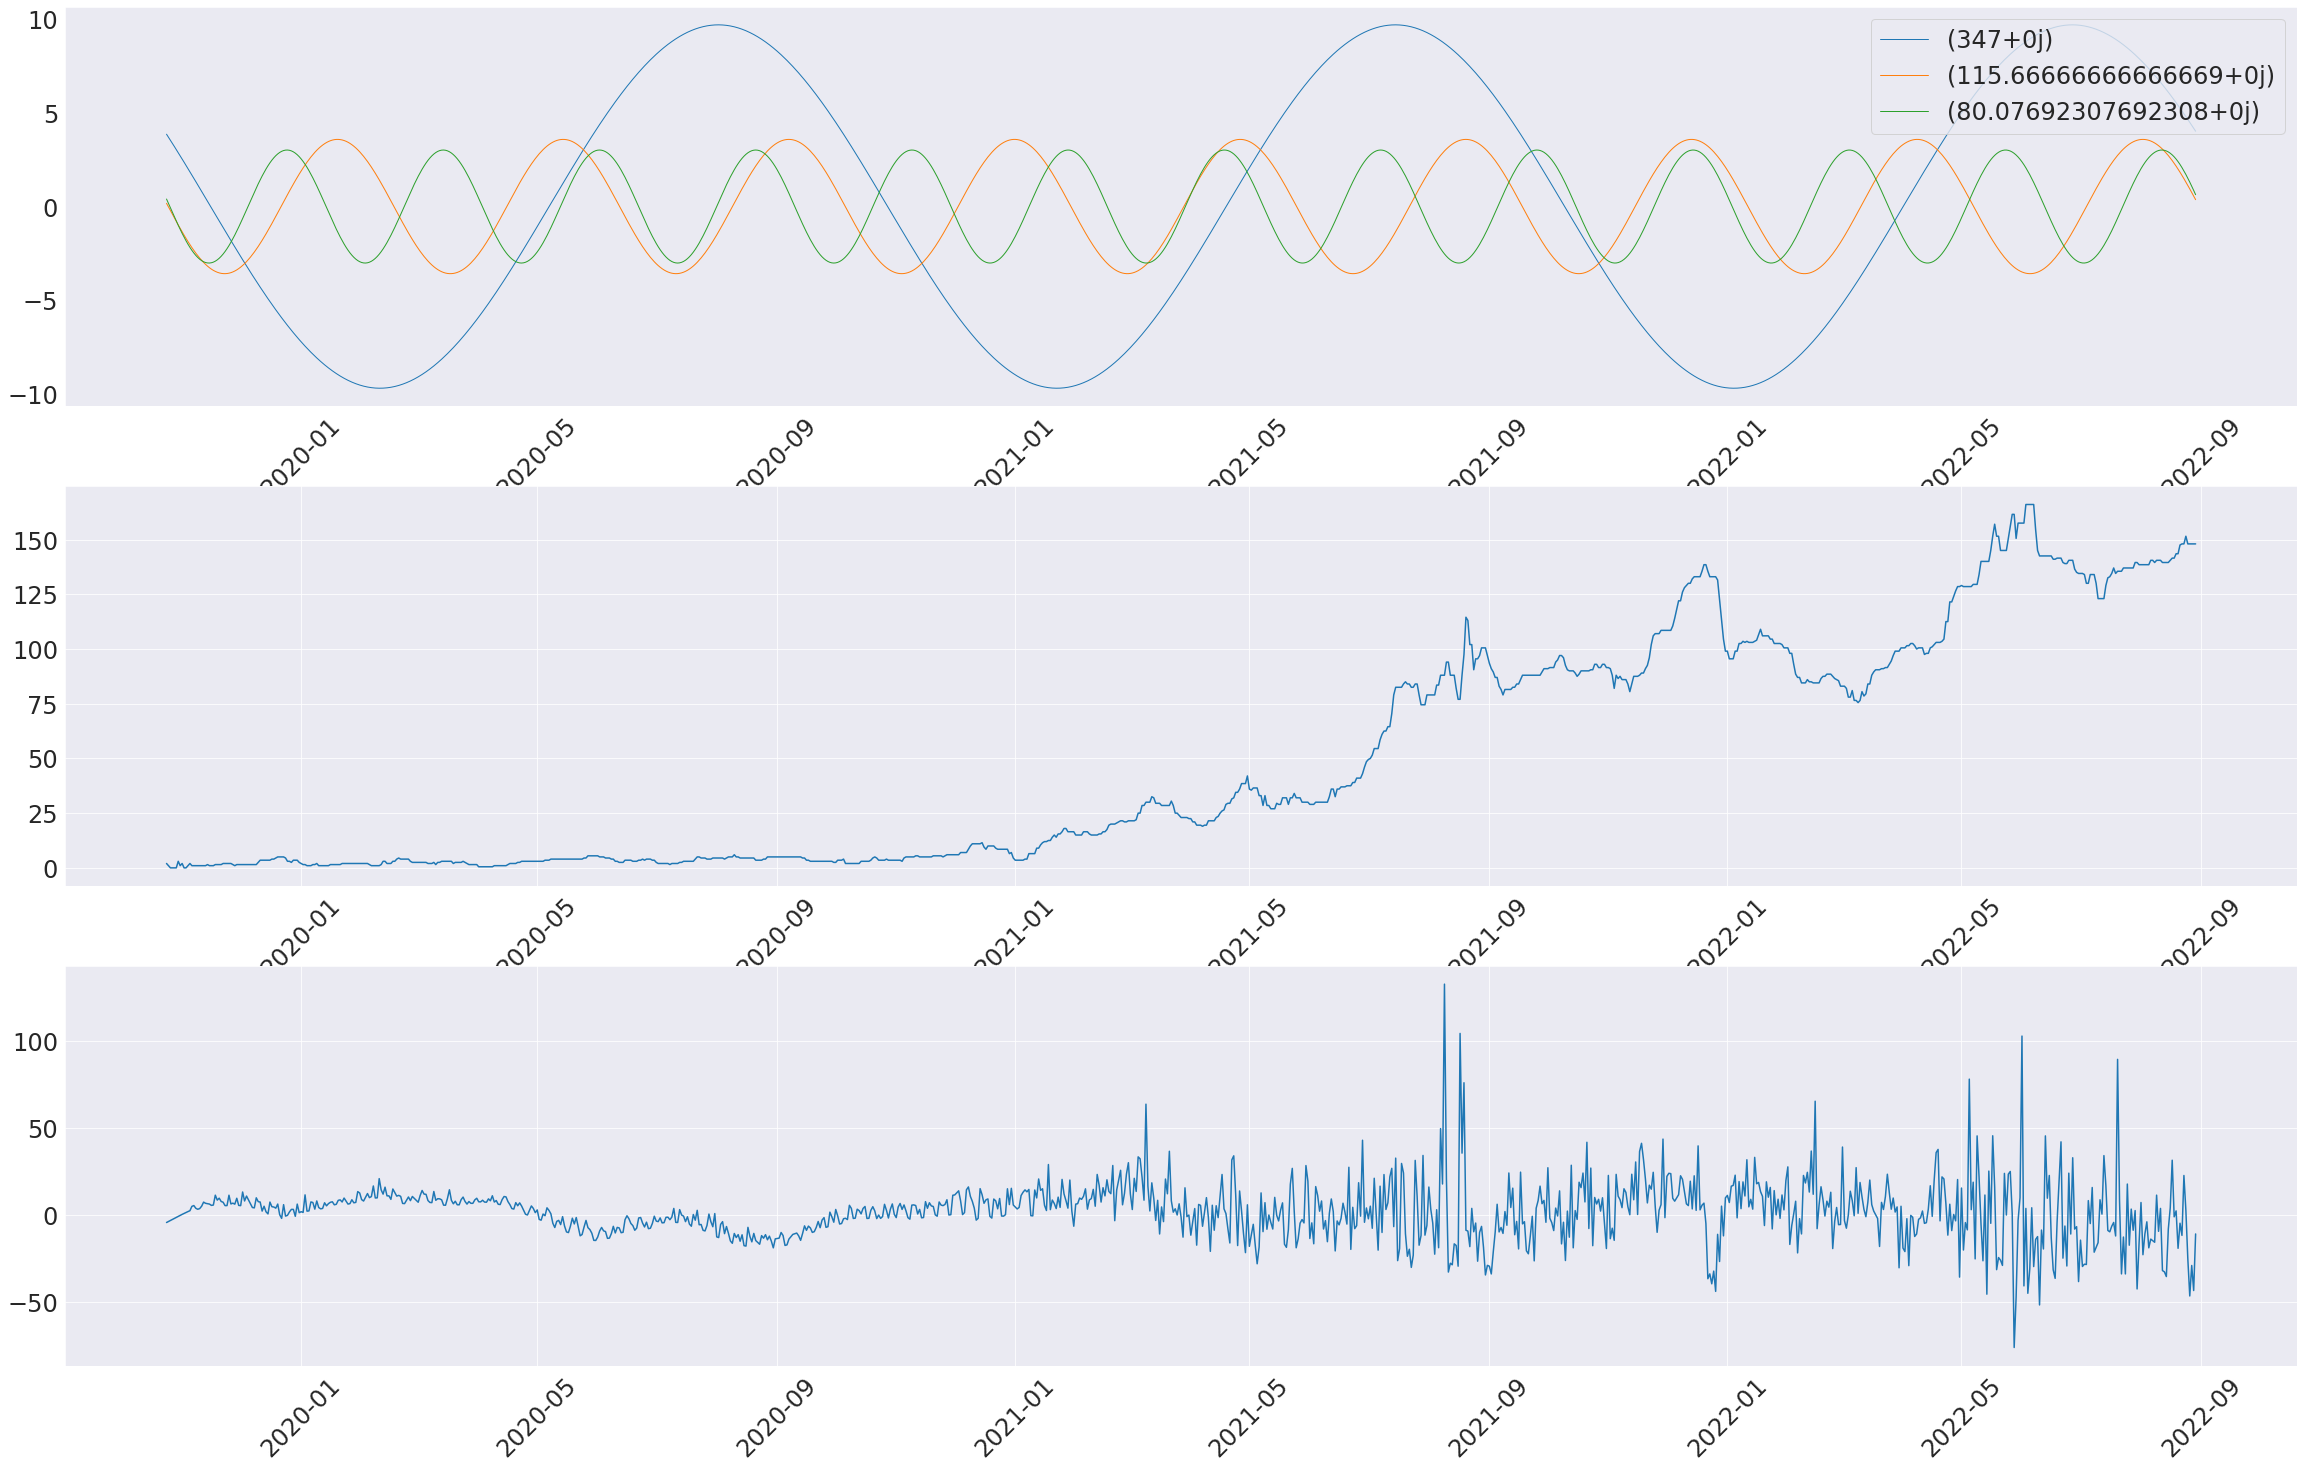

In [21]:
df = devs_vetted

seasonal = get_seasonality(df)
trend = get_trend(df)
error = get_error(df, trend, seasonal)

get_anomalies(error, seasonal, trend, df)

----------- (6.97887323943662+0j) ------------
7    2019-12-20
14   2019-12-27
21   2020-01-03
28   2020-01-10
35   2020-01-17
Name: index, dtype: datetime64[ns]
7     4
14    4
21    4
28    4
35    4
Name: index, dtype: int64
----------- (3.501766784452297+0j) ------------
3    2019-12-16
6    2019-12-19
10   2019-12-23
13   2019-12-26
17   2019-12-30
Name: index, dtype: datetime64[ns]
3     0
6     3
10    0
13    3
17    0
Name: index, dtype: int64
----------- (90.09090909090908+0j) ------------
60    2020-02-11
150   2020-05-11
241   2020-08-10
331   2020-11-08
421   2021-02-06
Name: index, dtype: datetime64[ns]
60     1
150    0
241    0
331    6
421    5
Name: index, dtype: int64


/tmp/ipykernel_1354/271925524.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies['index'].dt.day_name()).values


,index,devs_count,mean,day_name
648,2021-09-21,234,94.428571,Tuesday
698,2021-11-10,269,98.285714,Wednesday
756,2022-01-07,255,120.000000,Friday
759,2022-01-10,212,141.428571,Monday
760,2022-01-11,283,163.857143,Tuesday
...,...,...,...,...
975,2022-08-14,41,202.714286,Sunday
981,2022-08-20,44,205.000000,Saturday
982,2022-08-21,34,204.000000,Sunday
988,2022-08-27,11,175.714286,Saturday


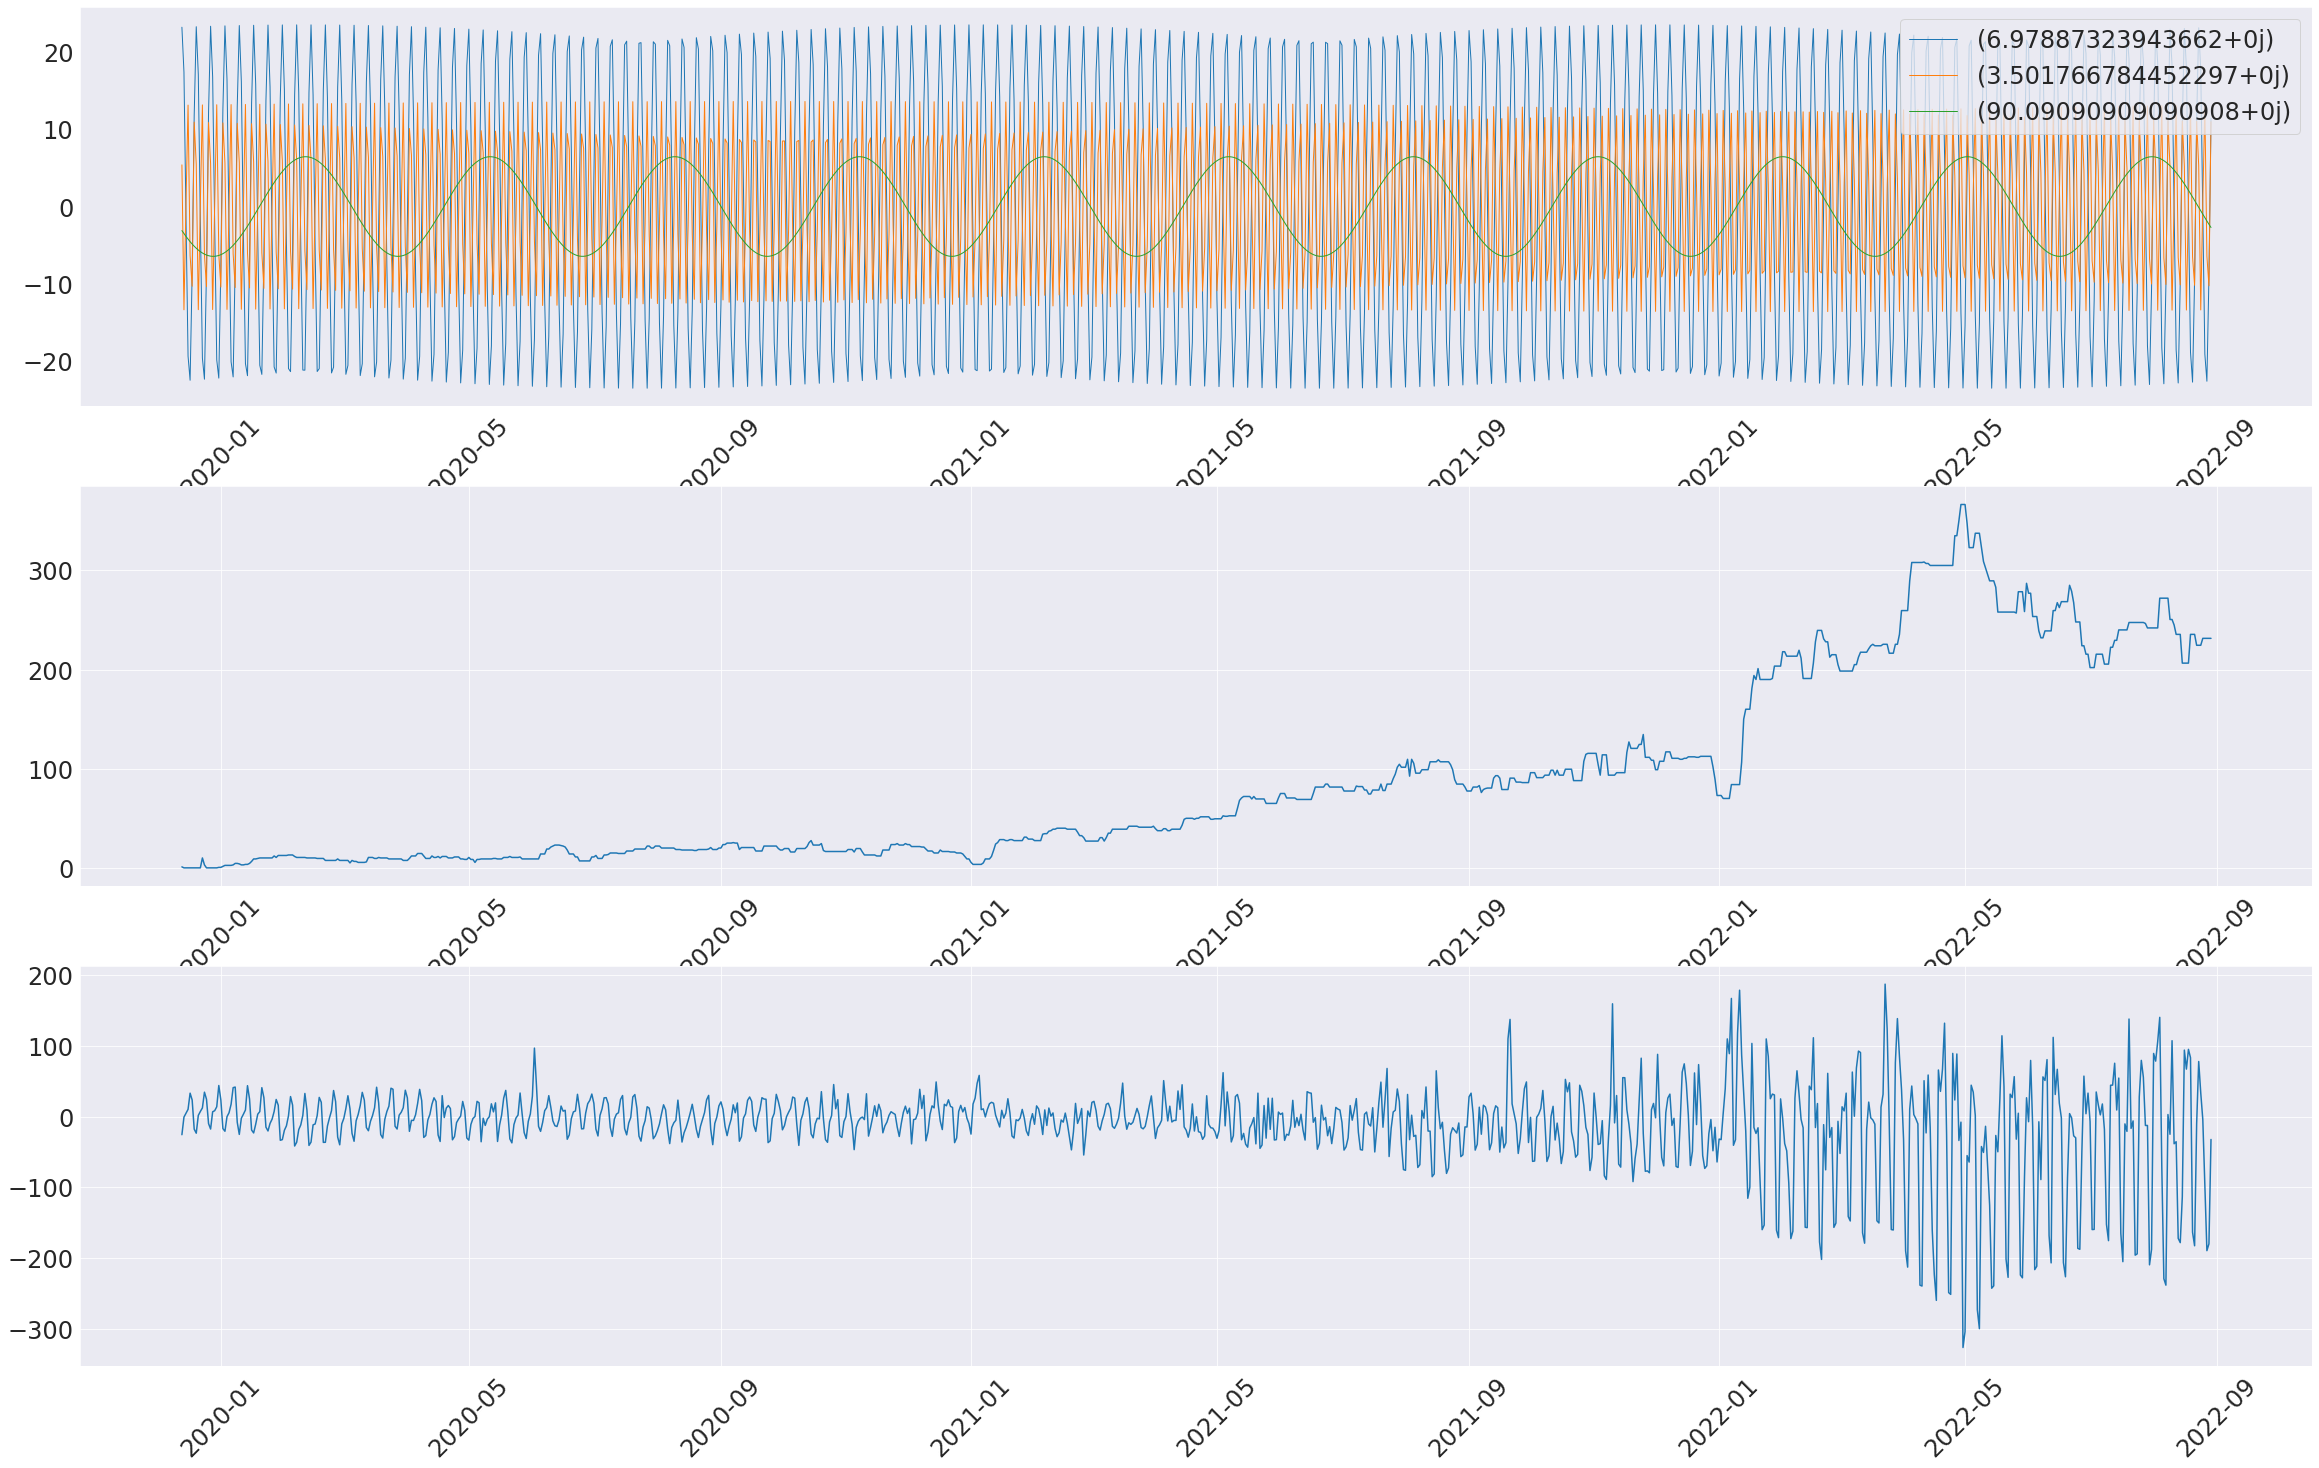

In [22]:
df = devs_shortlisted

seasonal = get_seasonality(df)
trend = get_trend(df)
error = get_error(df, trend, seasonal)

get_anomalies(error, seasonal, trend, df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1354/271925524.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies['index'].dt.day_name()).values


,index,devs_count,mean,day_name
204,2020-05-15,6,1.857143,Friday
321,2020-09-09,9,2.285714,Wednesday
511,2021-03-18,6,1.571429,Thursday
601,2021-06-16,8,3.000000,Wednesday
602,2021-06-17,10,3.571429,Thursday
...,...,...,...,...
1028,2022-08-17,15,5.428571,Wednesday
1031,2022-08-20,0,7.285714,Saturday
1032,2022-08-21,0,7.285714,Sunday
1038,2022-08-27,0,5.428571,Saturday


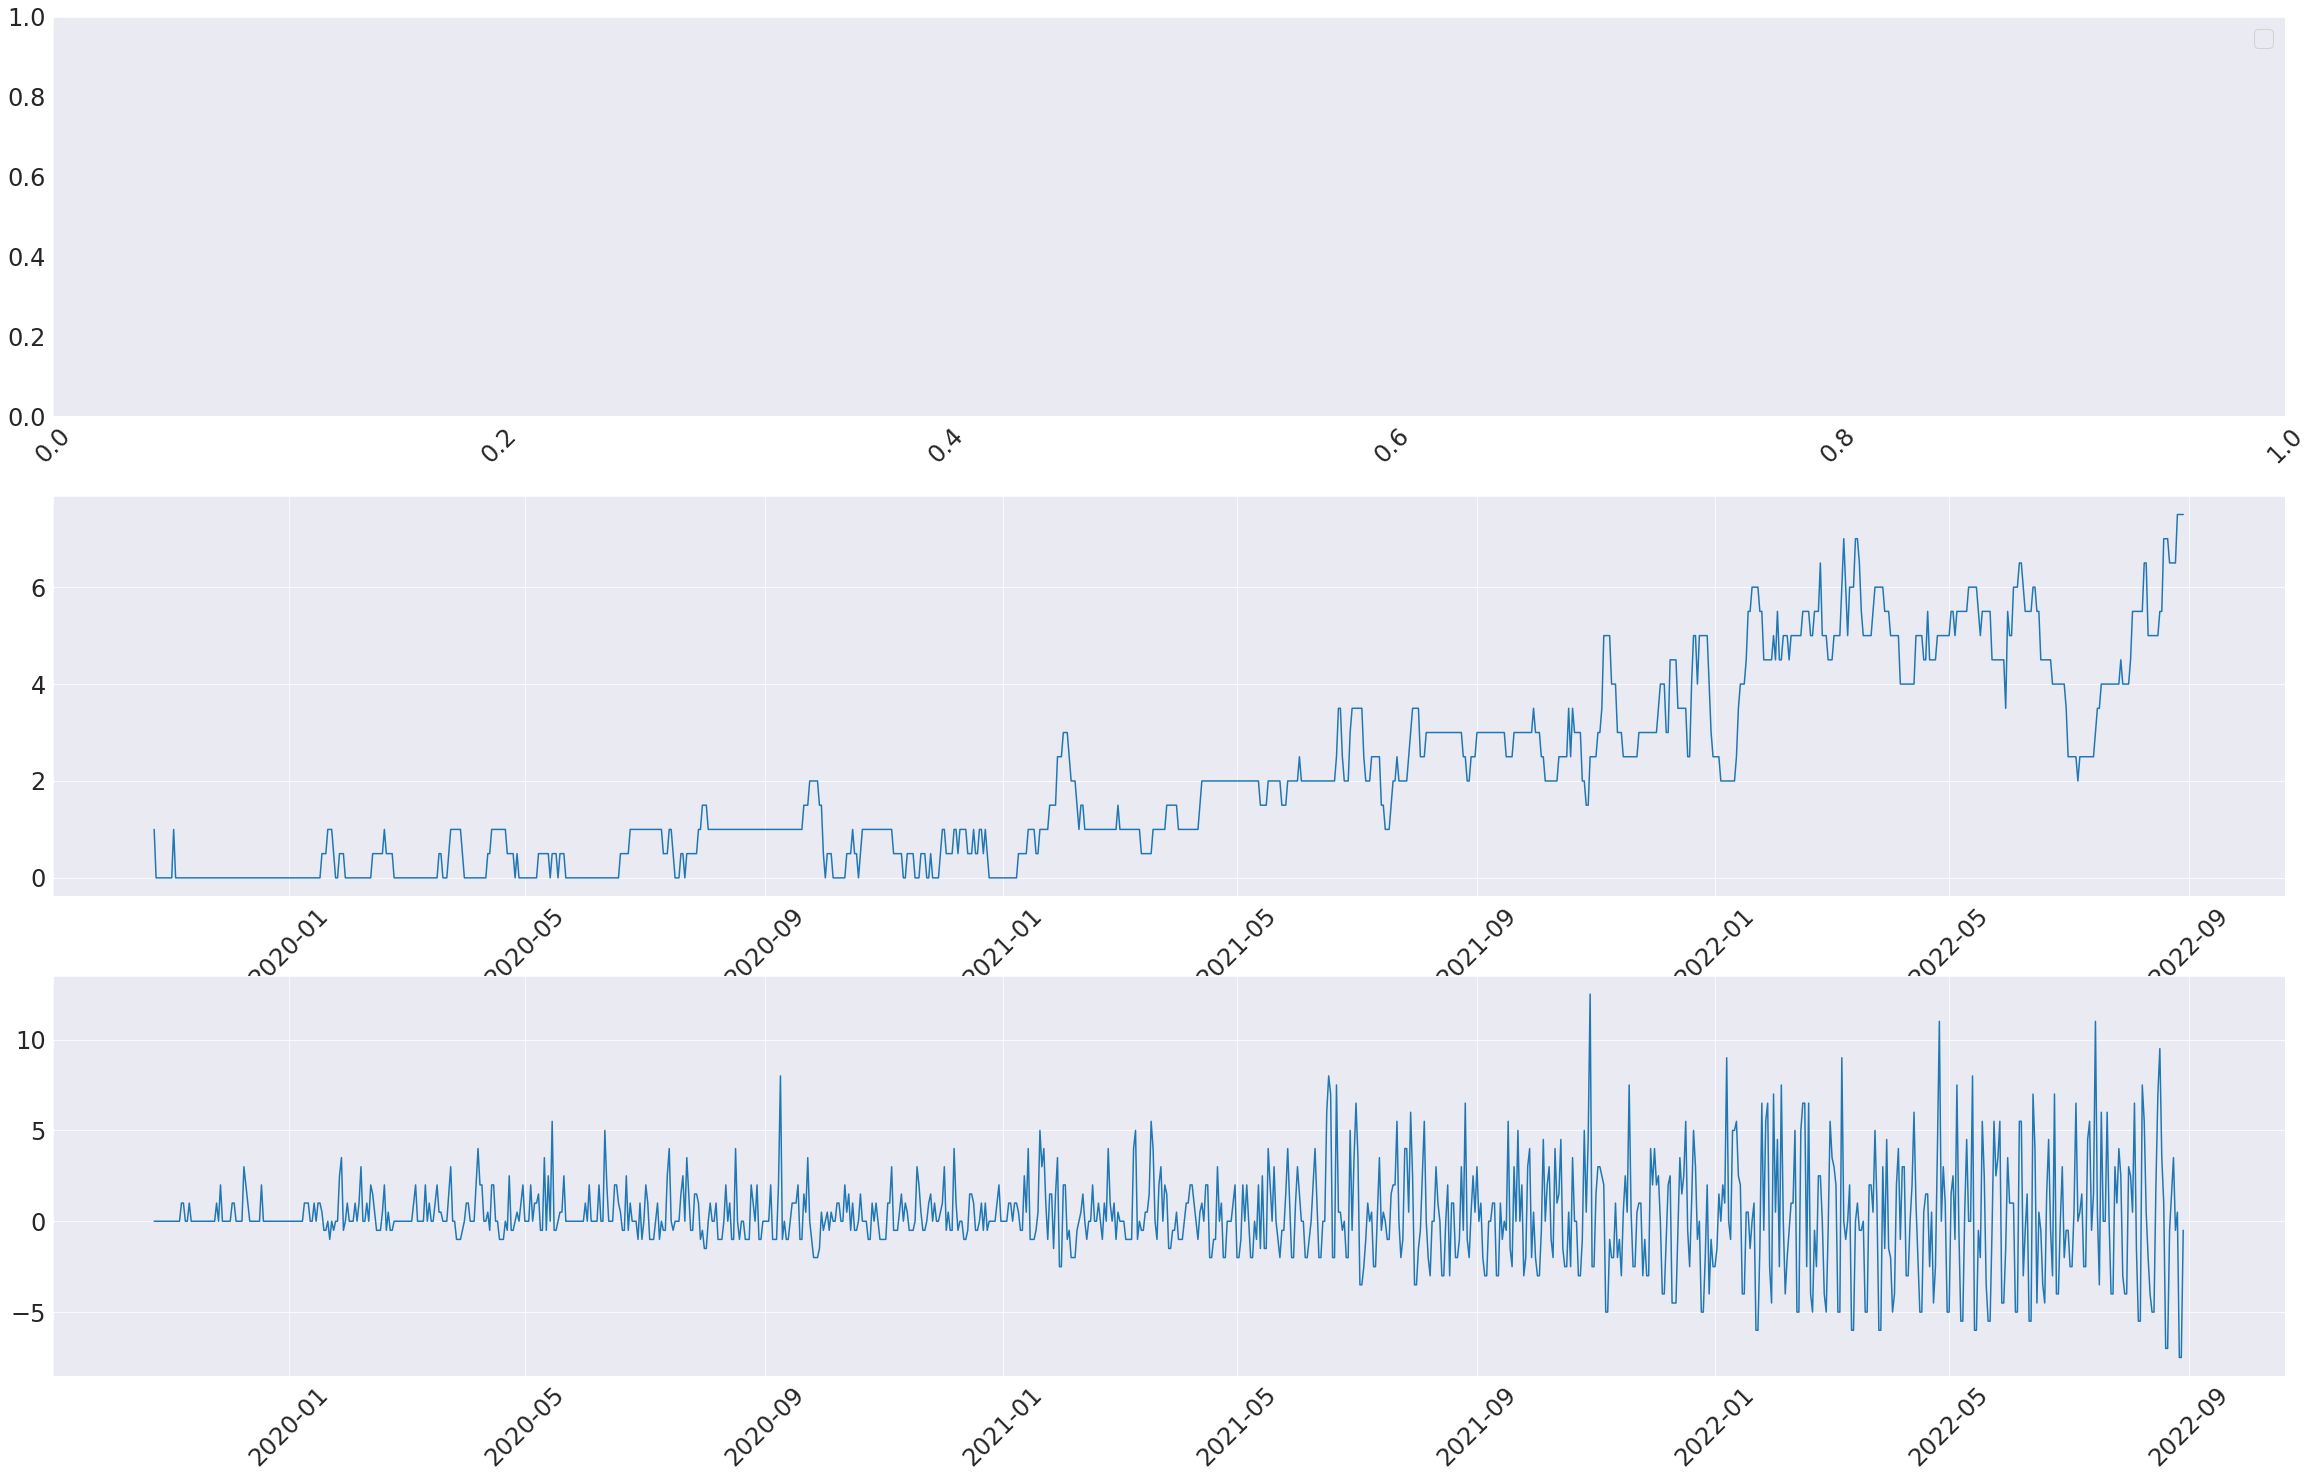

In [23]:
df = devs_chosen

seasonal = get_seasonality(df)
trend = get_trend(df)
error = get_error(df, trend, seasonal)

get_anomalies(error, seasonal, trend, df)